In [1]:
import os, sys, glob

import argparse
parser = argparse.ArgumentParser()
# Dataset
parser.add_argument('--set', type=str, default='valid')
# Model/Config
parser.add_argument('--step', type=str, default='050000')
parser.add_argument('--ckpt_selector', type=str, default='ema')
parser.add_argument('--cfg_name', type=str, default=None)
parser.add_argument('--log_dir', type=str, default=None)
# Interpolation
parser.add_argument('--interpolate', nargs='+', default=None)
parser.add_argument('--interpolate_step', type=int, default=15)
parser.add_argument('--interpolate_noise', action='store_true', default=False)
parser.add_argument('--lerp', action='store_true', default=False)
parser.add_argument('--slerp', action='store_true', default=False)
parser.add_argument('--uncond_sampling', action='store_true', default=False)
parser.add_argument('--uncond_sampling_iters', type=int, default=1)
parser.add_argument('--reverse_sampling', action='store_true', default=False)
parser.add_argument('--separate_reverse_sampling', action='store_true', default=False)
# Samples selection
parser.add_argument('--n_subject', type=int, default=-1)
parser.add_argument('--sample_pair_json', type=str, default=None)
parser.add_argument('--sample_pair_mode', type=str, default=None)
parser.add_argument('--src_dst', nargs='+', default=[])
# Pertubation the image condition
parser.add_argument('--perturb_img_cond', action='store_true', default=False)
parser.add_argument('--perturb_mode', type=str, default='zero')
parser.add_argument('--perturb_where', nargs='+', default=[])

# Rendering
parser.add_argument('--render_mode', type=str, default="shape")
parser.add_argument('--rotate_normals', action='store_true', default=False)
# Diffusion
parser.add_argument('--diffusion_steps', type=int, default=1000)
parser.add_argument('--denoised_clamp', type=float, default=None)
# Misc.
parser.add_argument('--seed', type=int, default=23)
parser.add_argument('--gpu_id', type=str, default="0")
parser.add_argument('--save_intermediate', action='store_true', default=False)
parser.add_argument('--postfix', type=str, default='')
parser.add_argument('--ovr_img', type=str, default=None)
parser.add_argument('--ovr_mod', action='store_true', default=False)
parser.add_argument('--norm_img', action='store_true', default=False)
parser.add_argument('--use_global_norm', action='store_true', default=False)
parser.add_argument('--norm_space', type=str, default='rgb')

args = parser.parse_args(args=[])

import os, sys, glob
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import PIL, cv2
import json
import copy
import time
import torchvision
import pytorch_lightning as pl
sys.path.insert(0, '../../../')
from guided_diffusion.script_util import (
    seed_all,
)

import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

from guided_diffusion.dataloader.img_deca_datasets import load_data_img_deca

# Sample utils
sys.path.insert(0, '../../')
from sample_utils import (
    ckpt_utils, 
    params_utils, 
    vis_utils, 
    file_utils, 
    inference_utils, 
    mani_utils,
)
device = 'cuda' if th.cuda.is_available() and th._C._cuda_getDeviceCount() > 0 else 'cpu'



In [2]:
seed_all(47)

################ SETTINGS ################
args.cfg_name = "original_dpm.yaml"
args.log_dir = "original_dpm"
args.step = '050000'
args.ckpt_selector = 'ema'
args.set = 'valid'
args.sample_pair_json = './sample_json/ipynb_samples.json'
args.sample_pair_mode = 'pair'

# Load Ckpt
if args.cfg_name is None:
    args.cfg_name = args.log_dir + '.yaml'
ckpt_loader = ckpt_utils.CkptLoader(log_dir=args.log_dir, cfg_name=args.cfg_name)
cfg = ckpt_loader.cfg

print(f"[#] Sampling with diffusion_steps = {args.diffusion_steps}")
cfg.diffusion.diffusion_steps = args.diffusion_steps
model_dict, diffusion = ckpt_loader.load_model(ckpt_selector=args.ckpt_selector, step=args.step)
model_dict = inference_utils.eval_mode(model_dict)

# Load dataset
if args.set == 'itw':
    img_dataset_path = "../../itw_images/aligned/"
    deca_dataset_path = None
elif args.set == 'train' or args.set == 'valid':
    img_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/ffhq_256/"
    deca_dataset_path = f"/data/mint/DPM_Dataset/ffhq_256_with_anno/params/"
else: raise NotImplementedError

loader, dataset, avg_dict = load_data_img_deca(
    data_dir=img_dataset_path,
    deca_dir=deca_dataset_path,
    batch_size=int(1e7),
    image_size=cfg.img_model.image_size,
    deterministic=cfg.train.deterministic,
    augment_mode=cfg.img_model.augment_mode,
    resize_mode=cfg.img_model.resize_mode,
    in_image_UNet=cfg.img_model.in_image,
    params_selector=cfg.param_model.params_selector,
    rmv_params=cfg.param_model.rmv_params,
    set_=args.set,
    cfg=cfg,
    mode='sampling'
)


[#] Model Path : 
#0 : /data/mint/model_logs_mount/v10/original_dpm/
[#] Config Path :  ['/home/mint/guided-diffusion/config/CVPRs/Original_DPM/original_dpm.yaml']
Merging with :  Namespace(cfg='/home/mint/guided-diffusion/config/CVPRs/Original_DPM/original_dpm.yaml')

[#] Sampling with diffusion_steps = 1000
[#] Available ckpt :  ['_000000.pt', '_010000.pt', '_020000.pt', '_030000.pt', '_040000.pt', '_050000.pt', '_060000.pt', '_070000.pt', '_080000.pt', '_090000.pt', '_100000.pt', '_110000.pt', '_120000.pt', '_130000.pt', '_140000.pt', '_150000.pt', '_160000.pt', '_170000.pt', '_180000.pt', '_190000.pt', '_200000.pt', '_210000.pt', '_220000.pt', '_230000.pt']
[#] Loading.../data/mint/model_logs_mount/v10/original_dpm//ImgCond_ema_0.9999_050000.pt


Loading deca params...: 100%|██████████| 10/10 [00:06<00:00,  1.62it/s]


[#] Bounding the input of UNet to +-1.0
[#] Parameters Conditioning
Params keys order :  []
Remove keys :  []
Image condition :  ['raw']
DPM Image condition :  [None]


In [3]:
data_size = dataset.__len__()
img_path = file_utils._list_image_files_recursively(f"{img_dataset_path}/{args.set}")

# DECA Rendering
# if np.any(['deca_masked' in n for n in list(filter(None, dataset.condition_image))]):
#     mask = params_utils.load_flame_mask()
# else: 
#     mask=None
# deca_obj = params_utils.init_deca(mask=mask)

denoised_fn = None
pl_sampling = inference_utils.PLSampling(model_dict=model_dict, 
                                            diffusion=diffusion, 
                                            reverse_fn=diffusion.ddim_reverse_sample_loop, 
                                            forward_fn=diffusion.ddim_sample_loop,
                                            denoised_fn=denoised_fn,
                                            cfg=cfg,
                                            args=args)

In [4]:
def inversion(dat, idx, use_global_norm, norm_img, model_kwargs, norm_space='gray'):
    '''
    :param dat: images in B x C x H x W
    '''
    dat = dat[[idx]]
    model_kwargs['use_cond_xt_fn'] = False
    model_kwargs['dpm_cond_img'] = None 
    cond = copy.deepcopy(model_kwargs)
    if norm_img:
        print(f"[#] Normalize image in {norm_space}...")
        def rgb_to_gray(img):
            out = (img[[0], [[0]], ...] * 0.2989) + (img[[0], [[1]], ...] * 0.5870) + (img[[0], [[2]], ...] * 0.1140)
            return out
        assert args.norm_space in ['gray', 'rgb']
        if args.norm_space == 'gray':
            gray_img = rgb_to_gray(dat)
            std_img, mu_img = th.std_mean(gray_img)
            mu_gray_dataset, std_gray_dataset = 114.49997340551313, 58.050383371049826
            mu_gray_dataset = (mu_gray_dataset/127.5) - 1
            std_gray_dataset = (std_gray_dataset/127.5)
            mu_dataset = mu_gray_dataset
            std_dataset = std_gray_dataset
        elif args.norm_space == 'rgb':
            std_img, mu_img = th.std_mean(dat)
            mu_rgb_dataset, std_rgb_dataset = 112.82840539423624, 62.779011111637864
            mu_rgb_dataset = (mu_rgb_dataset/127.5) - 1
            std_rgb_dataset = (std_rgb_dataset/127.5)
            mu_dataset = mu_rgb_dataset
            std_dataset = std_rgb_dataset
        else: raise ValueError(f"[#] Invalid : {args.norm_space}")
        
        img = (dat - mu_img) / std_img
        print(f"Local Normalization factor(mu, std) : {mu_img}, {std_img}")
        if use_global_norm:
            print("[#] Using global norm...")
            print(f"Global Normalization factor(mu, std) : {mu_dataset}, {std_dataset}")
            img = (img * std_dataset) + mu_dataset
     
    # Reverse   
    reverse_ddim_sample = pl_sampling.reverse_proc(x=img, model_kwargs=cond, store_intermediate=False)
    noise_map = reverse_ddim_sample['final_output']['sample']
    # Forward   
    sample_ddim = pl_sampling.forward_proc(noise=noise_map, model_kwargs=cond, store_intermediate=False)
    
    if norm_img:
        # Denormalize
        print("[#] DeNormalize image...")
        if use_global_norm:
            print("[#] Global DeNormalizing...")
            sample_ddim['final_output']['sample'] = (sample_ddim['final_output']['sample'] - mu_dataset) / std_dataset
            sample_ddim['final_output']['pred_xstart'] = (sample_ddim['final_output']['pred_xstart'] - mu_dataset) / std_dataset
        sample_ddim['final_output']['sample'] = (sample_ddim['final_output']['sample'] * std_img) + mu_img
        sample_ddim['final_output']['pred_xstart'] = (sample_ddim['final_output']['pred_xstart'] * std_img) + mu_img
        
    sample_frames = vis_utils.convert2rgb(sample_ddim['final_output']['sample'], cfg.img_model.input_bound) / 255.0
    
    return sample_frames

# Sampling is here

In [5]:
all_img_idx, all_img_name, args.n_subject = mani_utils.get_samples_list(args.sample_pair_json, 
                                                                        args.sample_pair_mode, 
                                                                        args.src_dst, img_path, 
                                                                        args.n_subject)

idx = 1 # Sample index related to json order
img_idx = all_img_idx[idx]
img_name = all_img_name[idx]

dat = th.utils.data.Subset(dataset, indices=img_idx)
subset_loader = th.utils.data.DataLoader(dat, batch_size=2,
                                    shuffle=False, num_workers=24)
                            
dat, model_kwargs = list(iter(subset_loader))[0]
show(torchvision.utils.make_grid((dat[[0]] + 1) * 127.5/255.0))
out = inversion(dat=dat, idx=0, use_global_norm=True, norm_img=True, model_kwargs=model_kwargs)

[#] Normalize image in gray...
Local Normalization factor(mu, std) : -0.4669653799019606, 0.42625438869644694
[#] Using global norm...
Global Normalization factor(mu, std) : -0.11507133024128435, 0.4923844008755911


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1, 3, 128, 128])


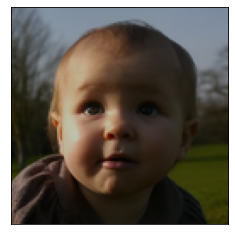

In [ ]:
print(out.shape)
show(torchvision.utils.make_grid(out))